In this notebook I am just going to try to get to 100% accuracy by any means possible.
Using the mnist sample I was able to get to 100% by just training for 100 epochs when using the existing simple model.
Mnist simple is only 3 and 7 though, would be interesting to see if it works though.

The other thing I could do is fully recreate resnet with a 28x28 input.
The model seems to be reasonably regular so it should be possible.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [171]:
from fastai.vision import *
from fastai.metrics import error_rate, accuracy
from fastai.callbacks import SaveModelCallback

from src.models.train_model import load_data
from src.models.predict_model import submission
from src.paths import TRAIN_FOLDER, TEST_FOLDER, SUBMISSION_CSV

To recreate resnet I must understand it.
Lets have a look:

In [5]:
models.resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

What I am seeing is three things:

 * The input to the model
 * The basic block, which may have an additional downsample (when it does it downsamples _twice_)
 * The output

So it should be possible to recreate this pretty simply.
I do have to consider the number of times that I am able to downsample the image though - the input is only 28x28.

28x28 -> 14x14 -> 7x7 -> 4x4? -> 2x2 -> 1x1

28x28 -> 14x14 -> 7x7 -> 3x3? -> 1x1

I do need to get to 1x1 (with 10 channels) however the output is already a fully connected layer so that isn't a big deal.
It looks like I can fit in 3 layers (one will be the input layer, one will be a non downsample, meaning 4 downsamples).

In [139]:
class Debug(nn.Module):
    def __init__(self, name):
        super().__init__()
        self.name = name
    
    def forward(self, input):
        print(f'{self.name}: {input.shape}')
        return input

class Reshape(nn.Module):
    # this is hidden in the implementation of resnet
    def __init__(self):
        super().__init__()

    def forward(self, input):
        return input.reshape(input.size(0), -1)

In [162]:
def _conv1x1(in_channels: int, out_channels: int, stride: int = 1) -> nn.Module:
    return nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)

def _conv3x3(in_channels: int, out_channels: int, stride: int = 1, padding: int = 1) -> nn.Module:
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=padding, bias=False)

def _normalize(channels: int) -> nn.Module:
    return nn.BatchNorm2d(channels)

def _relu() -> nn.Module:
    return nn.ReLU(inplace=True)

def _downsample_out(in_channels: int, out_channels: int) -> nn.Module:
    return nn.Sequential(
        _conv1x1(in_channels, out_channels, stride=2),
        _normalize(out_channels)
    )

class Basic(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, downsample: bool = False):
        super().__init__()
        
        if downsample:
            self.conv1 = _conv3x3(in_channels, out_channels, stride=2)
        else:
            self.conv1 = _conv3x3(in_channels, out_channels)

        self.bn1 = _normalize(out_channels)
        self.relu = _relu()
        self.conv2 = _conv3x3(out_channels, out_channels)
        self.bn2 = _normalize(out_channels)
        
        if downsample:
            self.downsample = _downsample_out(in_channels, out_channels)
        else:
            self.downsample = None

    def forward(self, input):
        identity = input

        out = self.conv1(input)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(input)

        out += identity
        out = self.relu(out)

        return out

In [163]:
def resnet() -> nn.Module:
    # (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    # (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    # (relu): ReLU(inplace)
    # (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    # ...
    # (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
    # (fc): Linear(in_features=512, out_features=1000, bias=True)
    
    module = nn.Sequential()
    
    module.add_module('conv1', nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False))
    module.add_module('bn1', nn.BatchNorm2d(64))
    module.add_module('relu', nn.ReLU(inplace=True))
    module.add_module('maxpool', nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    # This has downsampled twice at this point, so 28x28 -> 7x7
    
    module.add_module('layer1', nn.Sequential(Basic(64, 64), Basic(64, 64)))
    module.add_module('layer2', nn.Sequential(Basic(64, 128, downsample=True), Basic(128, 128)))
    module.add_module('layer3', nn.Sequential(Basic(128, 256, downsample=True), Basic(256, 256)))
    # 7x7 -> 1x1
    
    module.add_module('avgpool', nn.AdaptiveAvgPool2d(output_size=(1, 1)))
    module.add_module('reshape', Reshape())
    module.add_module('fc', nn.Linear(in_features=256, out_features=10))
    
    return module

In [164]:
model = resnet()

In [165]:
model.cuda()

Sequential(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Basic(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Basic(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(6

In [127]:
model

Sequential(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Sequential(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (debug_0): Debug()
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (debug_1): Debug()
      (relu): ReLU(inplace)
      (debug_2): Debug()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (debug_3): Debug()
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (debug_4): Debug()
    )
    (1): Sequential(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (de

It looks similar at least!

In [33]:
data = load_data(TRAIN_FOLDER, batch_size=1024)

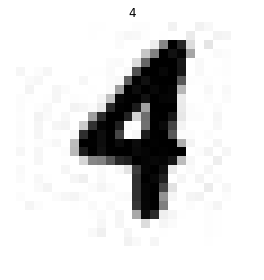

In [34]:
data.show_batch(rows=1)

In [166]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.45E-03
Min loss divided by 10: 6.31E-02


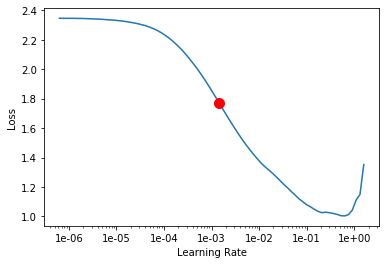

In [167]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [168]:
learn.fit_one_cycle(20)

In [172]:
model = resnet().cuda()
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [173]:
learn.fit_one_cycle(100, callbacks=[SaveModelCallback(learn, every='epoch', monitor='accuracy')])

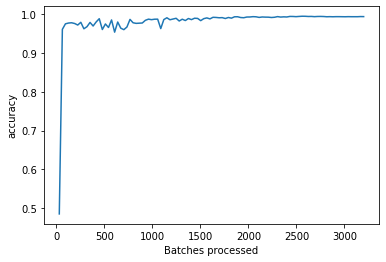

In [174]:
learn.recorder.plot_metrics()

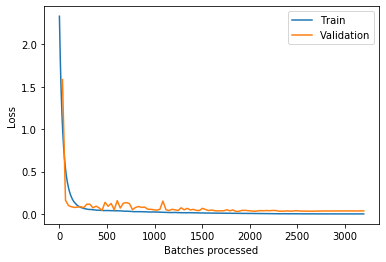

In [175]:
learn.recorder.plot_losses()